# Diabetes Classification for County Health Department

<img src="images/diabetes.jpeg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Overview
This project uses machine learning classification algorithms to predict whether a person has diabetes, as well as determine what are some of the most important features related to diabetes. A XGBoost model built using CDC survey data from 2015 predicts whether a person has diabetes with a 75% accuracy and 80% recall. The model determined general health, blood pressure, and BMI to be the most important features in predicting diabetes. This information can be used to inform guidance for future public health efforts.

## Business Understanding
The local health department wants to address the prevalence of diabetes in their community. A classification model for diabetes can predict which people are at risk as well as identify key risk factors that can be addressed with targeted health interventions.

## Data Understanding
This project uses 2015 survey data from the CDC's Behavioral Risk Factor Surveillance System. The dataset contains information about the health and lifestyle of 72,692 people. The target variable in this dataset is a binary with values of 1 meaning a person is pre-diabetic or diabetic and 0 meaning they are not pre-diabetic or diabetic.

In [2]:
#import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.feature_selection import RFE, RFECV
import shap
from sklearn.metrics import accuracy_score, recall_score
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [42]:
#import dataset and preview
df = pd.read_csv('data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [44]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,...,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,29.856985,0.475273,0.062171,0.147810,0.703036,0.611795,...,0.954960,0.093914,2.837082,3.752037,5.810417,0.252730,0.456997,8.584055,4.920953,5.698311
std,0.500004,0.495960,0.499342,0.155336,7.113954,0.499392,0.241468,0.354914,0.456924,0.487345,...,0.207394,0.291712,1.113565,8.155627,10.062261,0.434581,0.498151,2.852153,1.029081,2.175196
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [45]:
#class imbalance
df.Diabetes_binary.value_counts(normalize=True)

1.0    0.5
0.0    0.5
Name: Diabetes_binary, dtype: float64

## Data Preparation
Despite all the data being in numeric form, several features are actually categorical variables that need to be converted into dummy variables before modeling.

In [46]:
#convert categorical variables into dummy variables
categoricals = ['Education', 'Income']
categorical_df = df[categoricals].astype("category")
dummies = pd.get_dummies(categorical_df , drop_first=True)

In [47]:
#drop original categorical features from df and concat with dummy variables
df.drop(categoricals, axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

In [48]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Education_4.0,Education_5.0,Education_6.0,Income_2.0,Income_3.0,Income_4.0,Income_5.0,Income_6.0,Income_7.0,Income_8.0
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,1
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,1


In [49]:
#Split the data into target(y) and predictor(X) variables
y = df['Diabetes_binary']
X = df.drop('Diabetes_binary', axis=1)

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [50]:
#scale data using StandardScaler transformer
scaler = StandardScaler()
scaler.fit(X_train)

#convert scaled data back into datframes
X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                              columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                             columns=X_test.columns)

## Classification Modeling
To predict the binary diabetes target value, I will use a classification algorithm. I will iterate through multiple algorithms to determine the optimal model based on accuracy and recall.

### Logitic Regression

In [51]:
logreg_baseline = LogisticRegression(fit_intercept=False)

#run cross_validation
logreg_baseline_results  = cross_validate(logreg_baseline, X_train_scaled, y_train,
                                  scoring=('accuracy', 'recall'),
                                  return_train_score=True)

average_scores(logreg_baseline_results)

fit_time: 0.06687312126159668
score_time: 0.009372949600219727
test_accuracy: 0.7471284256432552
train_accuracy: 0.7479582799299533
test_recall: 0.7763862693323275
train_recall: 0.7771689928328932


#### Hyperparameter Tuning

In [87]:
logreg_param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                    'max_iter': [10000]}

logreg_grid = GridSearchCV(estimator=logreg_baseline,
                           param_grid=logreg_param_grid,
                           scoring=['accuracy', 'recall'],
                           refit='recall',
                           cv=3,
                           n_jobs=1,
                           return_train_score=True)

logreg_grid.fit(X_train_scaled, y_train)

best_parameters = logreg_grid.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
C: 10
max_iter: 10000
solver: 'newton-cg'


In [52]:
logreg_tuned = LogisticRegression(C=10, solver='newton-cg',
                                  max_iter=10000,
                                  fit_intercept=False)

#run cross_validation
logreg_tuned_results  = cross_validate(logreg_tuned, X_train_scaled, y_train,
                                  scoring=('accuracy', 'recall'),
                                  return_train_score=True)

average_scores(logreg_tuned_results)

fit_time: 0.22772274017333985
score_time: 0.009764480590820312
test_accuracy: 0.7471284256432552
train_accuracy: 0.747962995131764
test_recall: 0.7763862693323275
train_recall: 0.777159562429272


In [21]:
logreg_tuned.fit(X_train_scaled, y_train)

LogisticRegression(C=10, fit_intercept=False, max_iter=10000,
                   solver='newton-cg')

In [23]:
logreg_tuned.coef_[0]

array([ 0.36031682,  0.27235324,  0.18662211,  0.50598556, -0.01746405,
        0.05990609,  0.10465731, -0.02633948, -0.00518698, -0.0173923 ,
       -0.15731385,  0.00569895,  0.00156574, -0.02668852, -0.03673452,
        0.08180196,  0.13687598,  0.30373521,  0.64129806,  0.7172401 ,
        0.5410337 , -0.00279246,  0.0519414 ,  0.09620485,  0.17413381,
        0.25277205,  0.36382797,  0.4273193 ,  0.540847  ,  0.60896418,
        0.58219939,  0.47497132,  0.44153701,  0.05109876,  0.04779818,
        0.07459223,  0.09110741,  0.04507972, -0.00341837, -0.01297372,
       -0.02198658, -0.05304781, -0.07365178, -0.09076524, -0.19047264])

The hyperparameter tuning made little difference, increasing the recall score by only 0.001.

In [15]:
#funtion that displays model results
def average_scores(results):
    average_scores = {}
    for key, value in results.items():
        print(key+':', np.mean(value))

### Random Forest

In [59]:
#run baseline random forest algorithm
#instantiate random forest classifier
rf_baseline = RandomForestClassifier()

#run cross_validation
rf_baseline_results  = cross_validate(rf_baseline, X_train, y_train,
                                  scoring=('accuracy', 'recall'),
                                  return_train_score=True)

In [60]:
average_scores(rf_baseline_results)

fit_time: 3.1875038623809813
score_time: 0.2239957332611084
test_accuracy: 0.7361889030716025
train_accuracy: 0.9959259888183405
test_recall: 0.7733685401735194
train_recall: 0.994511505092418


While the test accuracy and recall are similar to the logistic regression model, the test metrics differ substantially from the training scores indicating that the current model is overfitting to the training data.

#### Hyperparameter Tuning

In [ ]:
rf_param_grid = {'max_depth': [5, 10, 25, 50, None],
 'max_features': ['auto', 5],
 'min_samples_leaf': [1, 2, 4]}

grid_rf = GridSearchCV(rf, rf_param_grid, scoring=['accuracy', 'recall'],
                        cv=3, n_jobs=1, refit='recall', return_train_score=True)
grid_rf.fit(X_train, y_train)

best_parameters = grid_rf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

In [63]:
#run baseline random forest algorithm
#instantiate random forest classifier
rf_tuned = RandomForestClassifier(max_depth=10, max_features=5, min_samples_leaf=4)

#run cross_validation
rf_tuned_results  = cross_validate(rf_tuned, X_train, y_train,
                                  scoring=('accuracy', 'recall'),
                                  return_train_score=True)

In [64]:
average_scores(rf_tuned_results)

fit_time: 1.695621633529663
score_time: 0.12248892784118652
test_accuracy: 0.7497879008570808
train_accuracy: 0.7689790529202278
test_recall: 0.792832893247831
train_recall: 0.8109392682006791


### XGBoost

In [65]:
#instantiate a baseline XGBoost Classifier
xgb_baseline = XGBClassifier()

#run cross-validation
xgb_baseline_results  = cross_validate(xgb_baseline, X_train, y_train,
                                  scoring=('accuracy', 'recall'),
                                  return_train_score=True)

In [66]:
average_scores(xgb_baseline_results)

fit_time: 0.8246486186981201
score_time: 0.028898859024047853
test_accuracy: 0.7472038884392235
train_accuracy: 0.7985863548162737
test_recall: 0.7879668049792531
train_recall: 0.8371463598642022


XGBoost has similarly high accuracy to the random forest classifier, but a lower recall.

#### Hyperparameter Tuning

In [17]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

grid_xgb = GridSearchCV(xgb, xgb_param_grid, scoring=['accuracy', 'recall'],
                        cv=3, n_jobs=1, refit='recall',
                        return_train_score=True)
grid_xgb.fit(X_train, y_train)

best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7


In [69]:
#instantiate a baseline XGBoost Classifier
xgb_tuned = XGBClassifier(learning_rate=0.1,
                         max_depth=5,
                         min_child_weight=1,
                         n_estimators=100,
                         subsample=0.7)

#run cross-validation
xgb_tuned_results  = cross_validate(xgb_tuned, X_train, y_train,
                                  scoring=('accuracy', 'recall'),
                                  return_train_score=True)

In [70]:
average_scores(xgb_tuned_results)

fit_time: 1.0095811843872071
score_time: 0.0251645565032959
test_accuracy: 0.7521454768589476
train_accuracy: 0.7646362613393294
test_recall: 0.7976612599019239
train_recall: 0.8106469256884195


### Feature Selection

In [24]:
selector = RFECV(logreg_tuned,cv=5)
selector = selector.fit(X_train_scaled, y_train)

In [ ]:
selector.support_.shape

In [39]:
for i in range(len(X_train.columns)):
    print(X_train.columns[i],':', selector.support_[i])

HighBP : True
HighChol : True
CholCheck : True
BMI : True
Smoker : True
Stroke : True
HeartDiseaseorAttack : True
PhysActivity : True
Fruits : False
Veggies : True
HvyAlcoholConsump : True
AnyHealthcare : True
NoDocbcCost : True
MentHlth : True
PhysHlth : True
DiffWalk : True
Sex : True
GenHlth_2.0 : True
GenHlth_3.0 : True
GenHlth_4.0 : True
GenHlth_5.0 : True
Age_2.0 : True
Age_3.0 : True
Age_4.0 : True
Age_5.0 : True
Age_6.0 : True
Age_7.0 : True
Age_8.0 : True
Age_9.0 : True
Age_10.0 : True
Age_11.0 : True
Age_12.0 : True
Age_13.0 : True
Education_2.0 : False
Education_3.0 : True
Education_4.0 : True
Education_5.0 : True
Education_6.0 : True
Income_2.0 : True
Income_3.0 : True
Income_4.0 : True
Income_5.0 : True
Income_6.0 : True
Income_7.0 : True
Income_8.0 : True


In [40]:
X_train_selected = selector.transform(X_train_resampled)

In [43]:
logreg_2 = LogisticRegression(fit_intercept=False)

logreg_2_baseline_results  = cross_validate(logreg_2, X_train_selected, y_train_resampled,
                                  scoring=('accuracy', 'recall'))


In [44]:
average_scores(logreg_2_baseline_results)

fit_time: 0.9416869640350342
score_time: 0.03151559829711914
test_accuracy: 0.7408769783285575
test_recall: 0.9060897497632421


## Final Model Evaluation

In [72]:
X_final = X_train_scaled
y_final = y_train

final_model = xgb_tuned
final_model.fit(X_final, y_final)

y_pred_test = final_model.predict(X_test_scaled)
y_pred_train = final_model.predict(X_train_scaled)


print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

Test Accuracy:  0.7578792508346065
Train Accuracy:  0.7631792376317924
Test Recall:  0.7990040742417384
Train Recall:  0.8088268577895134


In [116]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(final_model)
shap_values = explainer(X_final)

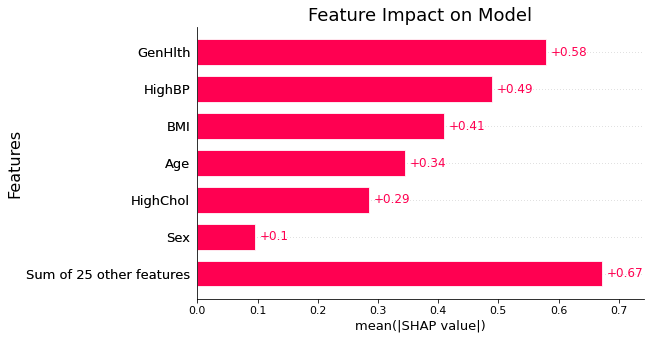

In [122]:
shap.plots.bar(shap_values, max_display=7, show=False)
plt.title('Feature Impact on Model', fontsize=18);
plt.ylabel('Features', fontsize=16)
plt.show();

## Conclusions

## Next Steps